In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
features = 16
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        
        # Encoder
        self.enc_fc1 = torch.nn.Linear(in_features=28*28, out_features=512)
        self.enc_fc2 = torch.nn.Linear(in_features=512, out_features=features*2)
        
        # Decoder
        self.dec_fc1 = torch.nn.Linear(in_features=features, out_features=512)
        self.dec_fc2 = torch.nn.Linear(in_features=512, out_features=28*28)
        
        
    def reparameterize(self, mu, log_var):
        """
        Recieves log variance and mu. Outputs a sample.
        """
        # We actually predict log(var^2). 
        # So e^(0.5 * log(var^2)) == e^(0.5 * 2 log(var)) == e^(log(var)) == var :) 
        var = torch.exp(0.5 * log_var) 
        eps = torch.randn_like(var) # Mean 0, Var 1
        sample = mu + eps * var # Gives us samples with mean MU and std VAR
        return sample
    
    
    def forward(self, x):
        x = F.relu(self.enc_fc1(x))
        x = self.enc_fc2(x).view(-1, 2, features)
        
        # We now have some latent representation with shape [N, feature * 2]
        # We will reshape it to shape [-1, 2, feature], so it's now [N, 2, features]
        # Where [:, 0, :] is the mean, and [:, 1, :] is the variance
        mean = x[:, 0, :]
        log_var = x[:, 1, :]
        reparameterized = self.reparameterize(mean, log_var)
        reconstructed = F.relu(self.dec_fc1(reparameterized))
        reconstructed = torch.sigmoid(self.dec_fc2(reconstructed))
        return reconstructed, mean, log_var

In [3]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [4]:
# leanring parameters
epochs = 10
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# train and validation data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader (
    train_data, 
    batch_size=batch_size,
    shuffle=True)

test_loader = DataLoader (
    val_data, 
    batch_size=batch_size,
    shuffle=False)

model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
bce_loss = nn.BCELoss(reduction="sum")

In [6]:
def compute_loss(reconstruction, gt, bce_loss, mu, logvar):
    # Reconstruction loss - ask the prediction to be like the GT (TODO: why not L1/L2? )
    bce_loss = bce_loss(reconstruction, gt)

    # Assuming that the real world distribution (==prior) is a gaussian with mean 0 and var 1.
    # The posterior (z given x) is computed by the encoder in the form of mean and var.
    # We want to minimize the distance (KL divergence in our case) between the prior and posterior.
    # The line below is a closed form solution of KL-divergence between: 
    # Gaussian with params (0,1) and gaussian with params (mu, var)
    deviation_from_normal_regualrizer =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_loss + deviation_from_normal_regualrizer


In [11]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        loss = compute_loss(reconstruction, data, bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss
    

In [8]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            loss = compute_loss(reconstruction, data, bce_loss, mu, logvar)
            running_loss += loss.item()
            
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
#                 print(f"epoch {epoch}: Mean {mu[0,:5]}. Mean {mu.mean()}")
#                 print(f"epoch {epoch}: Var: {torch.exp(0.5 * logvar)[0,:5]}. Mean {torch.exp(0.5 * logvar).mean()}")
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 1 of 10


938it [00:10, 92.79it/s]                          
 99%|█████████▊| 154/156 [00:01<00:00, 140.66it/s]

epoch 0: Mean tensor([ 1.2993,  0.4885, -0.6368,  0.9261,  2.3906], device='cuda:0'). Mean 0.35166531801223755
epoch 0: Var: tensor([0.4266, 0.4497, 0.4834, 0.5605, 0.5672], device='cuda:0'). Mean 0.6077345609664917


157it [00:01, 105.34it/s]                         


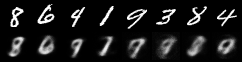

  1%|▏         | 13/937 [00:00<00:07, 121.87it/s]

Train Loss: 213.8025
Val Loss: 162.6908
Epoch 2 of 10


938it [00:09, 101.28it/s]                         
 96%|█████████▌| 150/156 [00:01<00:00, 130.98it/s]

epoch 1: Mean tensor([ 0.5739, -0.0123, -1.1150,  0.7609,  1.8267], device='cuda:0'). Mean 0.23115959763526917
epoch 1: Var: tensor([0.3390, 0.3260, 0.3318, 0.3975, 0.4090], device='cuda:0'). Mean 0.46390247344970703


157it [00:01, 103.70it/s]                         


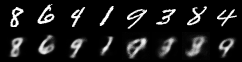

  1%|          | 8/937 [00:00<00:11, 77.78it/s]

Train Loss: 149.9805
Val Loss: 138.3046
Epoch 3 of 10


938it [00:09, 94.57it/s]                          
 93%|█████████▎| 145/156 [00:01<00:00, 127.01it/s]

epoch 2: Mean tensor([ 0.4370,  0.1589, -1.1776,  0.3838,  1.3642], device='cuda:0'). Mean 0.1684606522321701
epoch 2: Var: tensor([0.2679, 0.3014, 0.2929, 0.3397, 0.3027], device='cuda:0'). Mean 0.3986288905143738


157it [00:01, 106.81it/s]                         


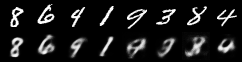

  1%|▏         | 13/937 [00:00<00:07, 125.20it/s]

Train Loss: 133.5530
Val Loss: 127.5278
Epoch 4 of 10


938it [00:09, 101.47it/s]                         
 95%|█████████▍| 148/156 [00:00<00:00, 152.56it/s]

epoch 3: Mean tensor([ 0.2378,  0.0070, -1.0073,  0.1390,  1.3746], device='cuda:0'). Mean 0.10709933191537857
epoch 3: Var: tensor([0.2286, 0.2868, 0.2724, 0.3046, 0.2756], device='cuda:0'). Mean 0.3628668189048767


157it [00:01, 124.94it/s]                         


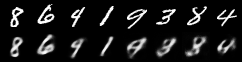

  1%|          | 8/937 [00:00<00:12, 75.07it/s]

Train Loss: 126.0891
Val Loss: 122.5957
Epoch 5 of 10


938it [00:09, 103.23it/s]                         
 96%|█████████▌| 149/156 [00:00<00:00, 142.50it/s]

epoch 4: Mean tensor([ 0.1400, -0.0350, -0.9325,  0.1698,  1.2501], device='cuda:0'). Mean 0.07825234532356262
epoch 4: Var: tensor([0.2128, 0.2735, 0.2412, 0.3059, 0.2649], device='cuda:0'). Mean 0.33264756202697754


157it [00:01, 121.49it/s]                         


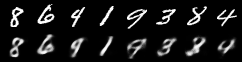

  1%|▏         | 14/937 [00:00<00:07, 119.77it/s]

Train Loss: 122.1694
Val Loss: 119.4869
Epoch 6 of 10


938it [00:09, 100.49it/s]                         
157it [00:01, 133.27it/s]                         

epoch 5: Mean tensor([ 0.1559, -0.1982, -0.9165,  0.2001,  1.3061], device='cuda:0'). Mean 0.060699187219142914
epoch 5: Var: tensor([0.2187, 0.2694, 0.2540, 0.3023, 0.2668], device='cuda:0'). Mean 0.3249448537826538


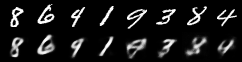

Train Loss: 119.5184
Val Loss: 117.3017
Epoch 7 of 10


938it [00:09, 100.29it/s]                         
 90%|█████████ | 141/156 [00:01<00:00, 120.92it/s]

epoch 6: Mean tensor([ 0.0398, -0.2141, -0.9023,  0.2169,  1.2726], device='cuda:0'). Mean 0.045084454119205475
epoch 6: Var: tensor([0.2022, 0.2612, 0.2355, 0.2930, 0.2500], device='cuda:0'). Mean 0.30268174409866333


157it [00:01, 108.72it/s]                         


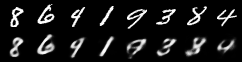

  1%|          | 7/937 [00:00<00:15, 60.06it/s]

Train Loss: 117.5203
Val Loss: 115.6084
Epoch 8 of 10


938it [00:09, 101.16it/s]                         
 88%|████████▊ | 138/156 [00:00<00:00, 137.09it/s]

epoch 7: Mean tensor([ 0.0822, -0.2786, -0.9749,  0.2435,  1.2505], device='cuda:0'). Mean 0.04950941354036331
epoch 7: Var: tensor([0.2069, 0.2583, 0.2262, 0.2978, 0.2445], device='cuda:0'). Mean 0.2979375123977661


157it [00:01, 102.18it/s]                         


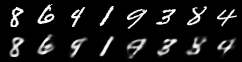

  1%|          | 9/937 [00:00<00:10, 88.42it/s]

Train Loss: 116.0111
Val Loss: 114.3248
Epoch 9 of 10


938it [00:08, 111.50it/s]                         
157it [00:00, 204.83it/s]                         

epoch 8: Mean tensor([-5.8809e-04, -3.6340e-01, -9.8096e-01,  3.2655e-01,  1.2528e+00],
       device='cuda:0'). Mean 0.037559498101472855
epoch 8: Var: tensor([0.1984, 0.2539, 0.2191, 0.2975, 0.2578], device='cuda:0'). Mean 0.293246865272522


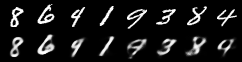

  0%|          | 0/937 [00:00<?, ?it/s]

Train Loss: 114.7992
Val Loss: 113.2190
Epoch 10 of 10


938it [00:08, 114.77it/s]                         
157it [00:01, 152.74it/s]                         

epoch 9: Mean tensor([-0.0676, -0.3322, -0.9279,  0.2685,  1.1850], device='cuda:0'). Mean 0.03851979970932007
epoch 9: Var: tensor([0.2021, 0.2484, 0.2051, 0.2876, 0.2576], device='cuda:0'). Mean 0.2833806872367859


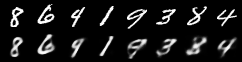

Train Loss: 113.7885
Val Loss: 112.5653


In [9]:
from IPython.display import Image, display
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, test_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    display(Image(f"outputs/output{epoch}.png"))
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")